In [52]:
library(parallel)
library(lme4)
library(mgcv)
library(xtable)

In [53]:
PATH_TO_DATA = '/Users/rachel/Documents/research/hla_ii/clean_matrices/'

Data requirements: patient tissues, patient mutations matrix, patient affinities matrix

In [54]:
get_or <- function(fit) { c(exp(c(coef(fit)[2,1],coef(fit)[2,1]-1.96*coef(fit)[2,2],coef(fit)[2,1]+1.96*coef(fit)[2,2])),coef(fit)[2,4]) }

In [51]:
coef(lme2)

$`pat[sel]`
             (Intercept) log(x[sel])
TCGA-3M-AB46   -4.735796  -0.1970379
TCGA-B7-5818   -4.174476  -0.1970379
TCGA-BR-4256   -3.672719  -0.1970379
TCGA-BR-4362   -4.171545  -0.1970379
TCGA-BR-4366   -4.739323  -0.1970379
TCGA-BR-6452   -4.169119  -0.1970379
TCGA-BR-6453   -4.738676  -0.1970379
TCGA-BR-6458   -4.173315  -0.1970379
TCGA-BR-6564   -4.740107  -0.1970379
TCGA-BR-6706   -4.735946  -0.1970379
TCGA-BR-6802   -4.178169  -0.1970379
TCGA-BR-7722   -4.740984  -0.1970379
TCGA-BR-7723   -4.735929  -0.1970379
TCGA-BR-7957   -4.735903  -0.1970379
TCGA-BR-8059   -4.174422  -0.1970379
TCGA-BR-8060   -4.736169  -0.1970379
TCGA-BR-8367   -4.735146  -0.1970379
TCGA-BR-8381   -4.732757  -0.1970379
TCGA-BR-8382   -4.170390  -0.1970379
TCGA-BR-8483   -4.736841  -0.1970379
TCGA-BR-8485   -4.739309  -0.1970379
TCGA-BR-8591   -4.170560  -0.1970379
TCGA-BR-8677   -4.739600  -0.1970379
TCGA-BR-8678   -4.739600  -0.1970379
TCGA-BR-8679   -4.174952  -0.1970379
TCGA-BR-8680   -3.668713  

In [64]:
#Format data
tissue <- read.csv(paste(PATH_TO_DATA, 'patient_tissues.csv', sep=""),header=TRUE)
mut <- read.csv(paste(PATH_TO_DATA, 'patient_mutations.cancer.csv', sep=""),header=TRUE)
aff <- read.csv(paste(PATH_TO_DATA, 'patient_affinities.cancer.csv', sep=""),header=TRUE)
patient <- as.character(mut[,1])
mut <- as.matrix(mut[,-1])
aff <- as.matrix(aff[,-1])
rownames(mut) <- rownames(aff) <- patient

In [9]:
y= as.vector(mut); x= as.vector(aff)
gene= rep(colnames(mut),each=nrow(mut))
pat= rep(rownames(mut),ncol(mut))
nmut= colSums(mut)
sel= gene %in% names(nmut[nmut>=5])

lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
summary(lme1)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | gene[sel])

     AIC      BIC   logLik deviance df.resid 
  7707.5   7735.4  -3850.7   7701.5    82997 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2644 -0.0935 -0.0672 -0.0598 17.0050 

Random effects:
 Groups    Name        Variance Std.Dev.
 gene[sel] (Intercept) 0.6026   0.7762  
Number of obs: 83000, groups:  gene[sel], 50

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -5.18510    0.27395 -18.927   <2e-16 ***
log(x[sel])  0.02063    0.08036   0.257    0.797    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.898

In [65]:
lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
summary(lme2)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
   421.5    440.8   -207.8    415.5     4547 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.2281 -0.0867 -0.0707 -0.0659 12.6023 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 0.6916   0.8316  
Number of obs: 4550, groups:  pat[sel], 91

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -4.5691     0.4864  -9.393   <2e-16 ***
log(x[sel])  -0.1970     0.1378  -1.430    0.153    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.806

ERROR: Error in coef(fit)[2, 1]: incorrect number of dimensions


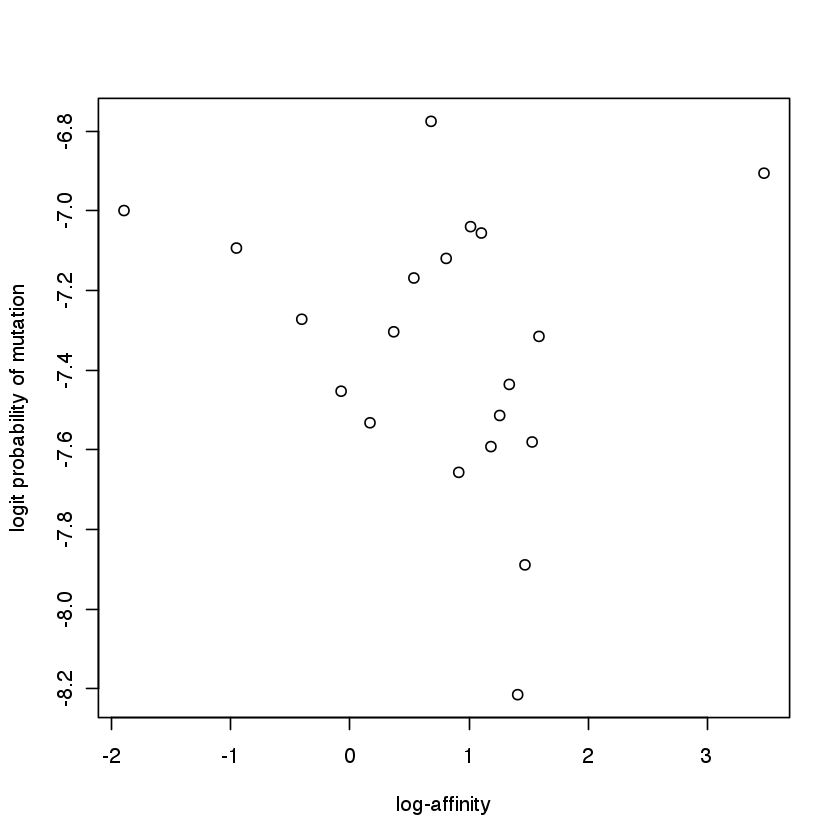

In [62]:
thre <- c(0,0.5,1,1.5,2,2.5,3,4,5,Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
thre <- c(seq(0,5,length=20),Inf)
xr= cut(x,breaks=thre)
m <- tapply(y,xr,'mean')
plot(log(tapply(x,xr,'mean')),log(m/(1-m)),xlab='log-affinity',ylab='logit probability of mutation')

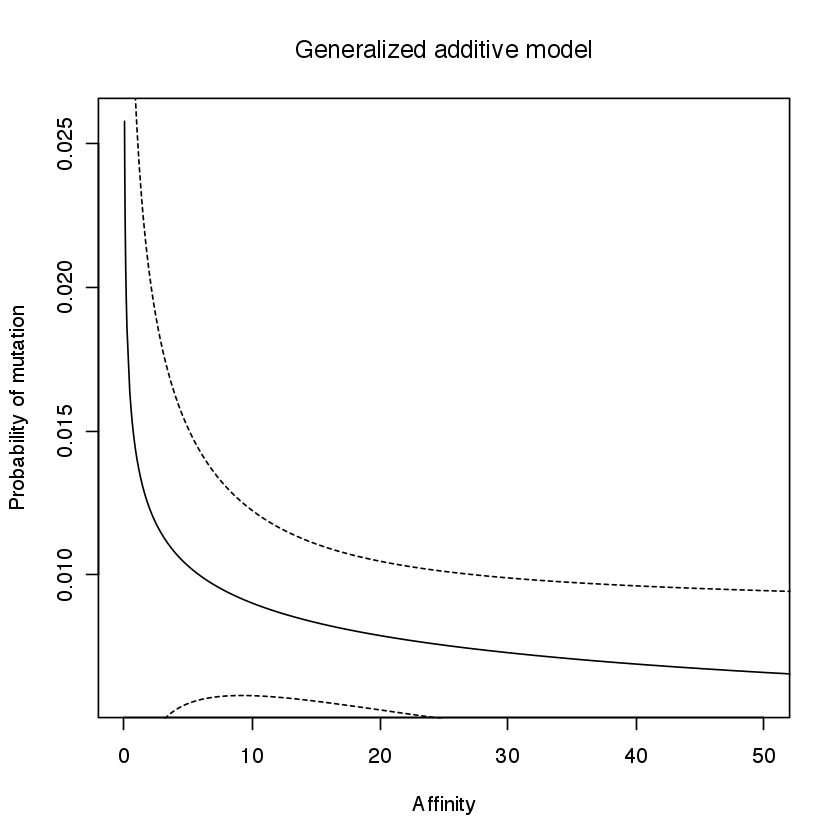

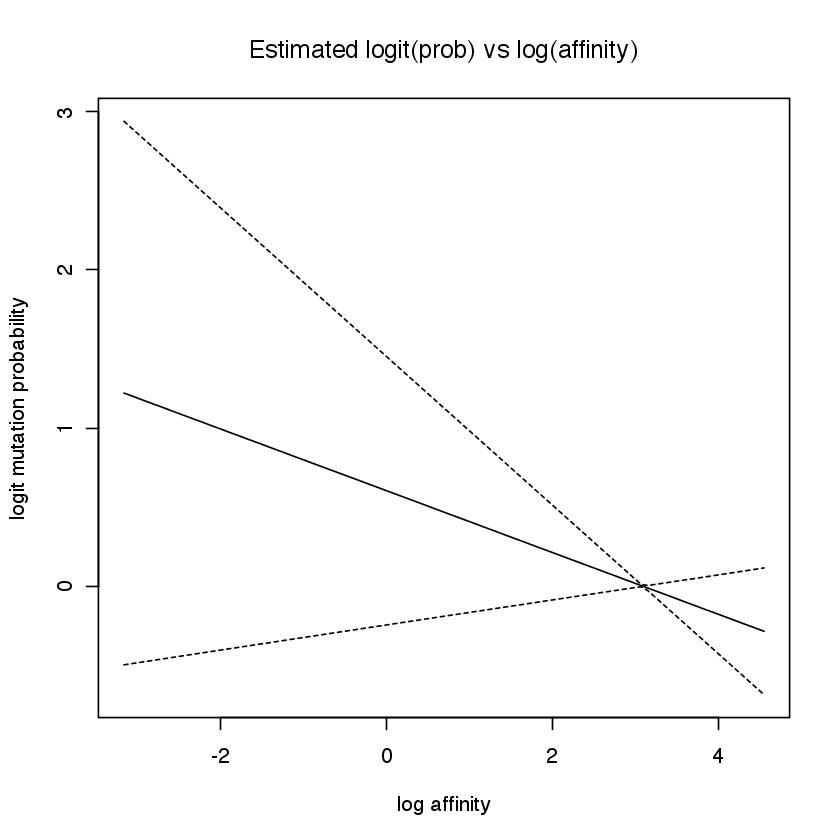

In [55]:
gam1= gam(y[sel] ~ s(log(x[sel])), family='binomial')
ypred= predict(gam1,type='response',se.fit=TRUE)
o= order(x[sel])
plot(x[sel][o],ypred$fit[o],type='l',xlim=c(0,50),xlab='Affinity',ylab='Probability of mutation',main='Generalized additive model')
lines(x[sel][o],ypred$fit[o]-1.96*ypred$se.fit[o],lty=2)
lines(x[sel][o],ypred$fit[o]+1.96*ypred$se.fit[o],lty=2)
#
plot(gam1,rug=FALSE,xlab='log affinity',ylab='logit mutation probability',main='Estimated logit(prob) vs log(affinity)')

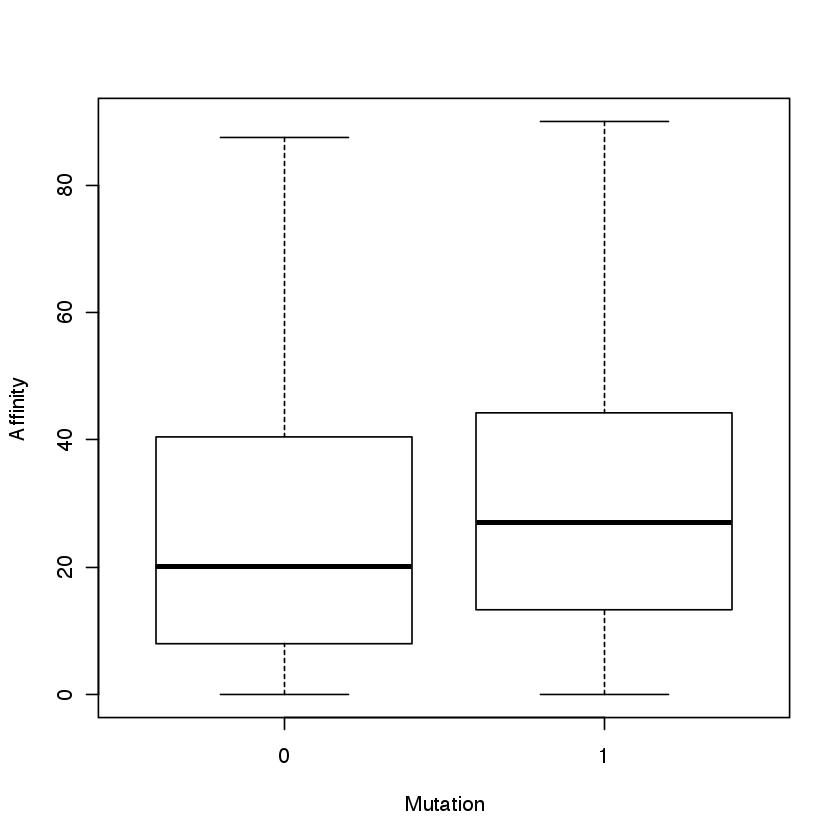

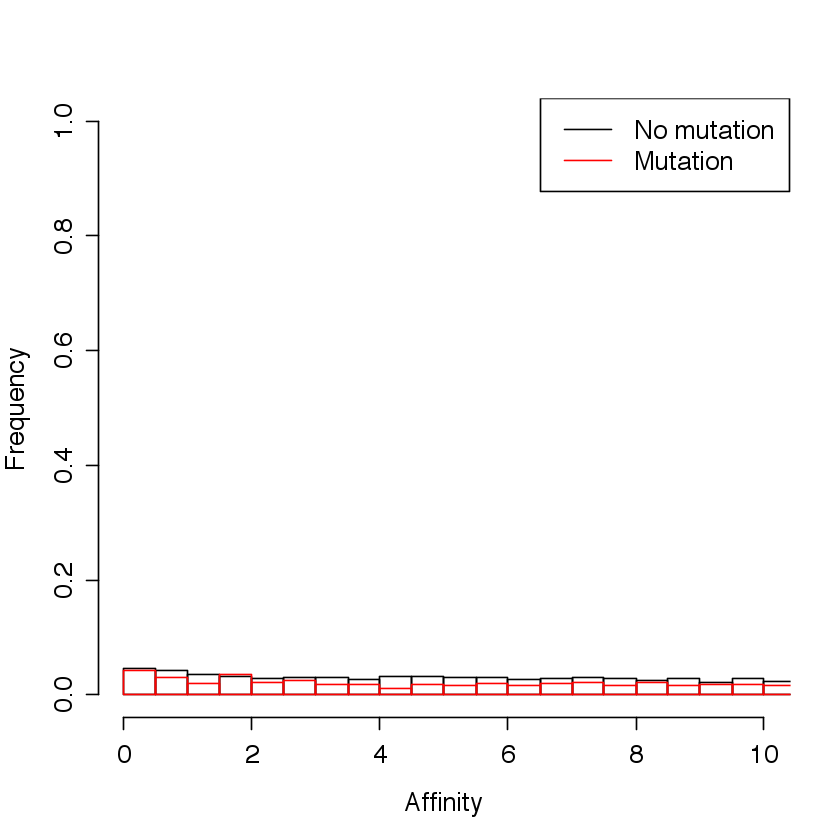

In [56]:
boxplot(x ~ y, outline=F, ylab='Affinity', xlab='Mutation')
#
hist(x[y==0],main='',xlim=c(0,10),ylim=c(0,1),prob=T,breaks=seq(0,100,by=.5),xlab='Affinity',ylab='Frequency',cex.lab=1.3,cex.axis=1.3)
par(new=TRUE)
hist(x[y==1],main='',xlim=c(0,10),ylim=c(0,1),prob=T,breaks=seq(0,100,by=.5),border=2,xaxt='n',yaxt='n',xlab='',ylab='')
legend('topright',c('No mutation','Mutation'),lty=1,col=1:2,cex=1.3)

## Panel C

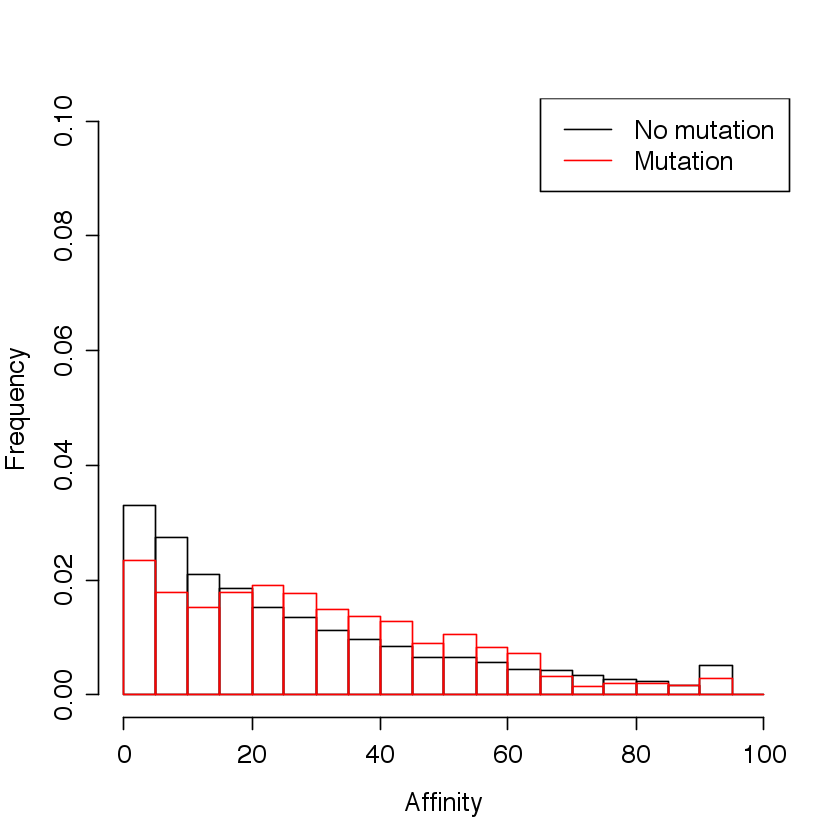

In [57]:
hist(x[y==0],main='',xlim=c(0,100),ylim=c(0,0.1),prob=T,breaks=seq(0,100,by=5),xlab='Affinity',ylab='Frequency',cex.lab=1.3,cex.axis=1.3)
par(new=TRUE)
hist(x[y==1],main='',xlim=c(0,100),ylim=c(0,0.1),prob=T,breaks=seq(0,100,by=5),border=2,xaxt='n',yaxt='n',xlab='',ylab='')
legend('topright',c('No mutation','Mutation'),lty=1,col=1:2,cex=1.3)

## Panel D

In [21]:
patient

[1] "TCGA-D3-A3CE" "TCGA-C5-A1BM" "TCGA-C5-A1BL" "TCGA-41-3915"
   [5] "TCGA-85-6560" "TCGA-ET-A4KN" "TCGA-2V-A95S" "TCGA-FY-A4B3"
   [9] "TCGA-CH-5789" "TCGA-DD-A4NH" "TCGA-DD-A4NN" "TCGA-DD-A4NO"
  [13] "TCGA-DD-A4NV" "TCGA-A3-A8OV" "TCGA-67-3770" "TCGA-06-A6S1"
  [17] "TCGA-06-A6S0" "TCGA-K7-A5RG" "TCGA-OE-A75W" "TCGA-16-1045"
  [21] "TCGA-DT-5265" "TCGA-77-8128" "TCGA-QK-A6IJ" "TCGA-60-2695"
  [25] "TCGA-QK-A6IF" "TCGA-FY-A3NN" "TCGA-YZ-A984" "TCGA-06-0145"
  [29] "TCGA-YZ-A980" "TCGA-XF-A8HC" "TCGA-XF-A8HF" "TCGA-XF-A8HI"
  [33] "TCGA-A5-A0GW" "TCGA-E7-A3Y1" "TCGA-A5-A0GA" "TCGA-A5-A0G9"
  [37] "TCGA-A5-A0G5" "TCGA-A5-A0G3" "TCGA-AA-3489" "TCGA-AB-2808"
  [41] "TCGA-NA-A4QY" "TCGA-06-0209" "TCGA-RD-A7BT" "TCGA-AB-2802"
  [45] "TCGA-VQ-A94P" "TCGA-DJ-A1QG" "TCGA-CX-A4AQ" "TCGA-BR-A4IY"
  [49] "TCGA-BR-A4IZ" "TCGA-75-5126" "TCGA-CZ-5984" "TCGA-EB-A4IQ"
  [53] "TCGA-FG-A711" "TCGA-CI-6622" "TCGA-A8-A09Z" "TCGA-CI-6620"
  [57] "TCGA-34-8455" "TCGA-AG-3727" "TCGA-A8-A09G" "TCGA-A8-A09I"
  [61] "TCGA-AG-4021" "TCGA-E3-A3E1" "TCGA-IA-A83S" "TCGA-DK-AA6M"
  [65] "TCGA-BF-A9VF" "TCGA-VM-A8CH" "TCGA-A4-8515" "TCGA-33-4582"
  [69] "TCGA-DK-AA6Q" "TCGA-56-8083" "TCGA-D8-A143" "TCGA-BQ-7061"
  [73] "TCGA-F4-6856" "TCGA-E2-A10A" "TCGA-BH-A0DO" "TCGA-B8-5549"
  [77] "TCGA-BH-A0DI" "TCGA-IQ-A61K" "TCGA-IQ-A61J" "TCGA-B8-5546"
  [81] "TCGA-G7-6790" "TCGA-13-0910" "TCGA-BH-A0DQ" "TCGA-EJ-A8FP"
  [85] "TCGA-A8-A090" "TCGA-A8-A095" "TCGA-A8-A097" "TCGA-76-4927"
  [89] "TCGA-CR-5243" "TCGA-12-0692" "TCGA-12-0691" "TCGA-XK-AAJR"
  [93] "TCGA-DH-A66D" "TCGA-BT-A0YX" "TCGA-HU-A4GY" "TCGA-AL-3468"
  [97] "TCGA-HU-A4GQ" "TCGA-3M-AB46" "TCGA-HU-A4GC" "TCGA-35-3615"
 [101] "TCGA-D3-A51N" "TCGA-AN-A04D" "TCGA-ZF-AA52" "TCGA-W3-AA1R"
 [105] "TCGA-B0-5077" "TCGA-ZF-AA5N" "TCGA-ZF-AA5P" "TCGA-22-1011"
 [109] "TCGA-CN-5369" "TCGA-24-1431" "TCGA-24-1430" "TCGA-EJ-8472"
 [113] "TCGA-HU-A4G3" "TCGA-AQ-A04J" "TCGA-61-2094" "TCGA-61-2096"
 [117] "TCGA-FC-A5OB" "TCGA-QT-A5XP" "TCGA-A4-A5XZ" "TCGA-QT-A5XN"
 [121] "TCGA-27-2526" "TCGA-QT-A5XL" "TCGA-A6-5664" "TCGA-A6-5667"
 [125] "TCGA-13-1409" "TCGA-HQ-A2OE" "TCGA-XJ-A83H" "TCGA-HT-8558"
 [129] "TCGA-RW-A67V" "TCGA-CQ-5330" "TCGA-YL-A8HM" "TCGA-B0-5097"
 [133] "TCGA-B0-5094" "TCGA-B0-5092" "TCGA-FR-A7U9" "TCGA-55-8302"
 [137] "TCGA-CM-6161" "TCGA-CM-6163" "TCGA-CM-6165" "TCGA-CM-6166"
 [141] "TCGA-CQ-6227" "TCGA-BR-6452" "TCGA-BR-6453" "TCGA-CQ-6223"
 [145] "TCGA-BR-6458" "TCGA-B0-4842" "TCGA-HI-7171" "TCGA-P5-A780"
 [149] "TCGA-VP-A87K" "TCGA-EI-7002" "TCGA-CQ-7069" "TCGA-D7-A4YU"
 [153] "TCGA-VP-A872" "TCGA-EJ-AB20" "TCGA-V4-A9F0" "TCGA-D7-A4YY"
 [157] "TCGA-06-0157" "TCGA-E2-A1B1" "TCGA-DW-5560" "TCGA-OR-A5JT"
 [161] "TCGA-43-A56U" "TCGA-44-7659" "TCGA-HC-7819" "TCGA-B8-A54F"
 [165] "TCGA-MZ-A5BI" "TCGA-AO-A12A" "TCGA-AA-3492" "TCGA-AA-3495"
 [169] "TCGA-AA-3494" "TCGA-63-5128" "TCGA-AO-A12H" "TCGA-B6-A0X0"
 [173] "TCGA-34-5236" "TCGA-CV-6962" "TCGA-AB-2813" "TCGA-AB-2812"
 [177] "TCGA-Z5-AAPL" "TCGA-OR-A5L2" "TCGA-26-5133" "TCGA-DA-A1I8"
 [181] "TCGA-CV-5432" "TCGA-CV-5430" "TCGA-HZ-8002" "TCGA-CV-5435"
 [185] "TCGA-OR-A5LT" "TCGA-BR-8679" "TCGA-OR-A5LP" "TCGA-DA-A1IC"
 [189] "TCGA-DK-A3IT" "TCGA-PQ-A6FI" "TCGA-BR-8677" "TCGA-OR-A5LF"
 [193] "TCGA-DK-A3IN" "TCGA-OR-A5LD" "TCGA-OR-A5LE" "TCGA-OR-A5LB"
 [197] "TCGA-B1-A657" "TCGA-AZ-4681" "TCGA-23-1110" "TCGA-AZ-4684"
 [201] "TCGA-09-2055" "TCGA-BH-A0E9" "TCGA-BQ-7053" "TCGA-D3-A1Q6"
 [205] "TCGA-EJ-7781" "TCGA-DK-AA76" "TCGA-DK-AA75" "TCGA-18-3406"
 [209] "TCGA-ZF-AA4W" "TCGA-18-3409" "TCGA-18-3408" "TCGA-DD-AAE6"
 [213] "TCGA-A5-A0R7" "TCGA-GF-A2C7" "TCGA-DD-AAW2" "TCGA-25-1319"
 [217] "TCGA-A4-8098" "TCGA-DD-AAEB" "TCGA-DD-AAED" "TCGA-DD-AAEG"
 [221] "TCGA-QR-A6H3" "TCGA-TM-A7C5" "TCGA-AO-A0JC" "TCGA-EI-6507"
 [225] "TCGA-KS-A4IB" "TCGA-6A-AB49" "TCGA-EB-A430" "TCGA-CN-5370"
 [229] "TCGA-CN-5373" "TCGA-SH-A7BH" "TCGA-HV-AA8V" "TCGA-DS-A1OC"
 [233] "TCGA-HZ-7919" "TCGA-DS-A1OA" "TCGA-GN-A8LN" "TCGA-2Y-A9GW"
 [237] "TCGA-ZG-A9LZ" "TCGA-27-2519" "TCGA-E8-A3X7

In [20]:
unique(tissue[,2])

[1] MESO BRCA UCS  LUSC GBM  READ KICH COAD SKCM STAD THCA PRAD CESC BLCA UVM 
[16] ACC  LGG  UCEC TGCT OV   LAML LUAD LIHC HNSC PCPG KIRP SARC DLBC KIRC PAAD
30 Levels: ACC BLCA BRCA CESC COAD DLBC GBM HNSC KICH KIRC KIRP LAML ... UVM

In [58]:
#tissuetypes <- as.character(unique(tissue[,2]))
tissuetypes <- c('HNSC', 'LUAD', 'PRAD', 'LUSC', 'LGG', 'BRCA', 'GBM', 'STAD')
mysummary0 <- mysummary1 <- mysummary2 <- vector("list",length(tissuetypes))
names(mysummary0) <- names(mysummary1) <- names(mysummary2) <- tissuetypes
for (i in 1:length(tissuetypes)) {
    message("TISSUE",tissuetypes[i])
    #
    patsel= pat %in% as.character(tissue$Sample[tissue$Tissue==tissuetypes[i]])
    sel= genesel & patsel
    #
    lme0= glm(y[sel] ~ log(x[sel]), family='binomial')
    mysummary0[[i]] <- summary(lme0)
    #
    lme1= glmer(y[sel] ~ log(x[sel]) + (1|gene[sel]), family='binomial')
    mysummary1[[i]] <- summary(lme1)
    #
    lme2= glmer(y[sel] ~ log(x[sel]) + (1|pat[sel]), family='binomial')
    mysummary2[[i]] <- summary(lme2)
    message("Done \n")
}

TISSUEHNSC
Done 

TISSUELUAD
Done 

TISSUEPRAD
Done 

TISSUELUSC
Done 

TISSUELGG
Done 

TISSUEBRCA
Done 

TISSUEGBM
Done 

TISSUESTAD
Done 



In [44]:
mysummary2['HNSC']

$HNSC
Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: y[sel] ~ log(x[sel]) + (1 | pat[sel])

     AIC      BIC   logLik deviance df.resid 
   543.5    563.6   -268.8    537.5     5897 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-0.0972 -0.0920 -0.0897 -0.0862 15.7348 

Random effects:
 Groups   Name        Variance Std.Dev.
 pat[sel] (Intercept) 4e-14    2e-07   
Number of obs: 5900, groups:  pat[sel], 118

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -5.2541     0.5365  -9.793   <2e-16 ***
log(x[sel])   0.1300     0.1614   0.806     0.42    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
            (Intr)
log(x[sel]) -0.961


In [48]:
coef(mysummary2['HNSC'])

NULL

In [59]:
tabgene <- do.call(rbind,lapply(mysummary1,get_or))
tabpat <- do.call(rbind,lapply(mysummary2,get_or))
xtable(tabgene[order(rownames(tabgene)),],digits=c(0,3,3,3,4))
xtable(tabpat[order(rownames(tabpat)),],digits=c(0,3,3,3,4))
npat <- table(tissue$Tissue)

,1,2,3,4
BRCA,0.6405671,0.4074460,1.007069,0.05367063
GBM,1.2837884,0.7216519,2.283806,0.39531098
HNSC,0.9838728,0.6075626,1.593261,0.94729142
LGG,0.9583787,0.5094035,1.803069,0.89510989
LUAD,1.6371904,0.8448987,3.172442,0.14411376
LUSC,0.9687669,0.5800980,1.617846,0.90347284
PRAD,0.9525691,0.5493099,1.651869,0.86264407
STAD,0.8398108,0.5957224,1.183911,0.31904377


,1,2,3,4
BRCA,0.7753636,0.6224420,0.9658551,0.0232098258
GBM,1.3244695,0.8606437,2.0382644,0.2013682950
HNSC,1.1388648,0.8299841,1.5626963,0.4204983896
LGG,1.4944197,1.1779931,1.8958433,0.0009347511
LUAD,1.7886933,1.1681918,2.7387829,0.0074684423
LUSC,1.0397084,0.7120573,1.5181272,0.8402088991
PRAD,0.9502838,0.5364275,1.6834319,0.8612453923
STAD,0.8211595,0.6267780,1.0758242,0.1528066459


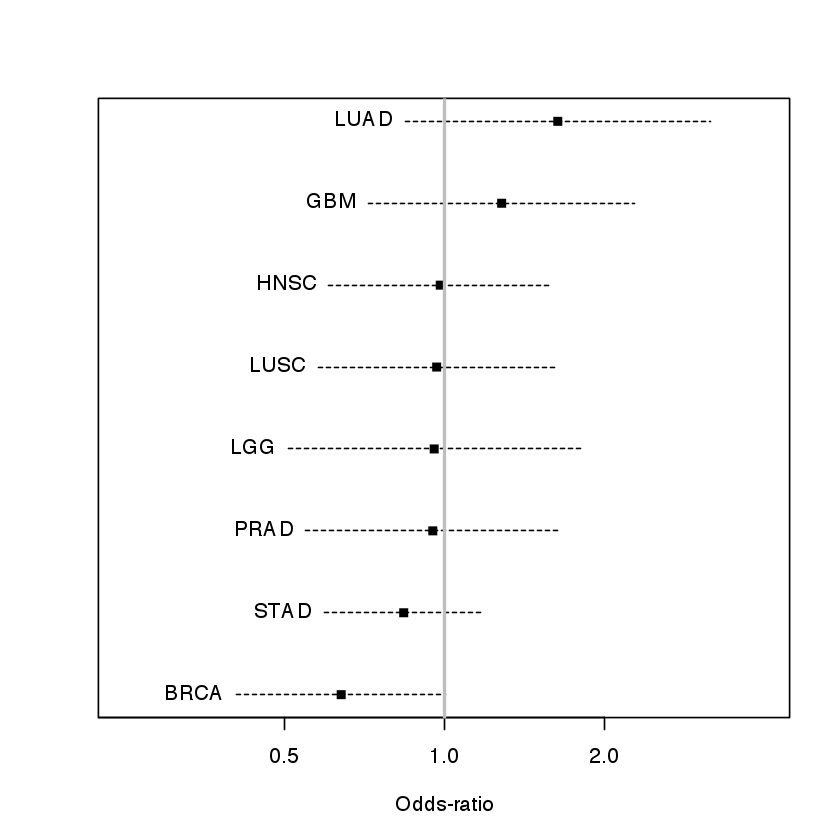

In [60]:
x2plot <- tabgene[order(tabgene[,1]),]
x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,4),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)

## Panel E

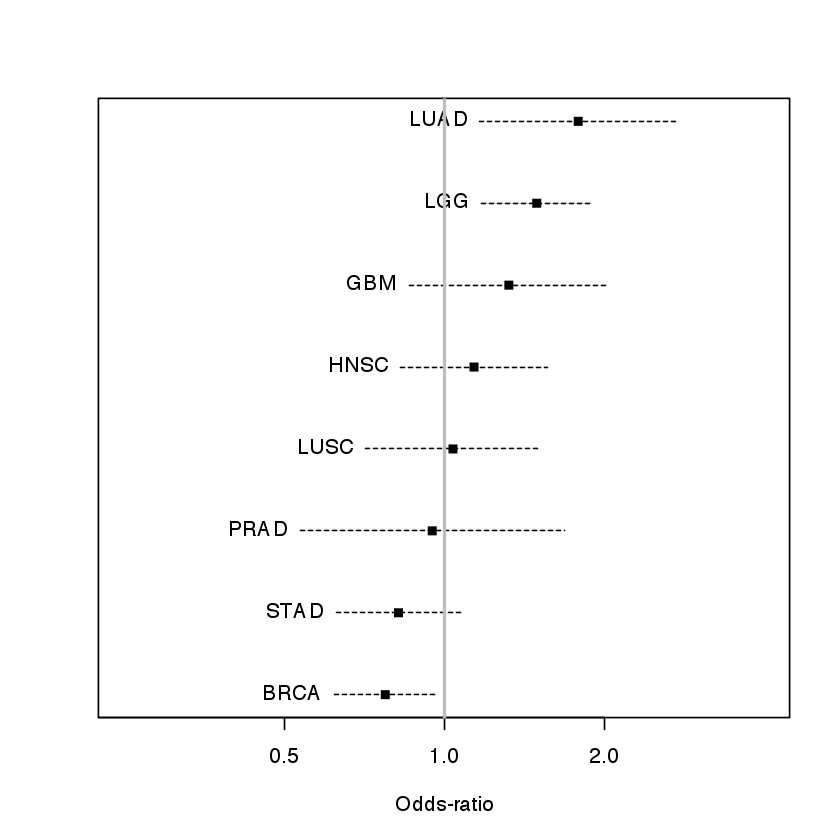

In [61]:
x2plot <- tabpat[order(tabpat[,1]),]
x2plot <- x2plot[rownames(x2plot) %in% names(npat[npat>=100]), ]
plot(x2plot[,1],1:nrow(x2plot),pch=15,xlim=c(0.25,4),yaxt='n',ylab='',xlab='Odds-ratio',log='x')
segments(x0=x2plot[,2],x1=x2plot[,3],1:nrow(x2plot),lty=2)
text(x2plot[,2],1:nrow(x2plot),rownames(x2plot),pos=2)
abline(v=1,col='gray',lwd=2)